## Use FIQA-PL corpus, including documents, questions and relations between them.

In [46]:
from elasticsearch import Elasticsearch
from datasets import load_dataset
import pandas as pd
import numpy as np

ds = load_dataset("clarin-knext/fiqa-pl", "corpus")
df_corpus = pd.DataFrame(ds['corpus'])
print(df_corpus.head())

ds_q = load_dataset("clarin-knext/fiqa-pl", "queries")
ds_q = ds_q['queries']
print(ds_q[0])

ds_qrels = load_dataset("clarin-knext/fiqa-pl-qrels")
df_qrels = pd.DataFrame(ds_qrels['train'])
print(df_qrels.head())

df_corpus = df_corpus.rename(columns={'_id': 'id'})
df_corpus['id'] = df_corpus['id'].astype(np.int64)

  _id title                                               text
0   3        Nie mówię, że nie podoba mi się też pomysł szk...
1  31        Tak więc nic nie zapobiega fałszywym ocenom po...
2  56        Nigdy nie możesz korzystać z FSA dla indywidua...
3  59        Samsung stworzył LCD i inne technologie płaski...
4  63        Oto wymagania SEC: Federalne przepisy dotycząc...
{'_id': '0', 'title': '', 'text': 'Co jest uważane za wydatek służbowy w podróży służbowej?'}
   query-id  corpus-id  score
0         0      18850      1
1         4     196463      1
2         5      69306      1
3         6     560251      1
4         6     188530      1


In [47]:
ds_q_dict = dict()
for q in ds_q:
    ds_q_dict[int(q['_id'])] = q['text']
print(ds_q_dict[5993])

Dlaczego ktokolwiek miałby chcieć najpierw spłacić swoje długi w inny sposób niż „najwyższe odsetki”?


In [48]:
df_joined = pd.merge(df_corpus, df_qrels, left_on='id', right_on='corpus-id', how='left').drop(columns=['corpus-id'])
df_joined.fillna({'score': 0, 'query-id': -1}, inplace=True)
print(df_joined.head())

   id title                                               text  query-id  \
0   3        Nie mówię, że nie podoba mi się też pomysł szk...      -1.0   
1  31        Tak więc nic nie zapobiega fałszywym ocenom po...      -1.0   
2  56        Nigdy nie możesz korzystać z FSA dla indywidua...      -1.0   
3  59        Samsung stworzył LCD i inne technologie płaski...      -1.0   
4  63        Oto wymagania SEC: Federalne przepisy dotycząc...    1927.0   

   score  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    1.0  


In [50]:
elasticsearch = Elasticsearch(hosts=["http://localhost:9200"])
print(elasticsearch.info())

{'name': 'node-1', 'cluster_name': 'my-application-cluster', 'cluster_uuid': 'u0kJ5q17SEet7EfPPRTUoQ', 'version': {'number': '8.15.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '98adf7bf6bb69b66ab95b761c9e5aadb0bb059a3', 'build_date': '2024-09-19T10:06:03.564235954Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [51]:
synonyms_set = [{"id": "synonym-1", "synonyms": "kwiecień, kwi, IV"}]

elasticsearch.synonyms.put_synonym(id="months-synonyms", synonyms_set=synonyms_set)

analyzers = ["lowercase_analyzer", "polish_analyzer_morfologik_included", "polish_analyzer_synonyms_included"]

settings = {
    "analysis": {
        "analyzer": {
            "lowercase_analyzer": {
                "tokenizer": "standard",
                "filter": ["lowercase"],
            },
            "polish_analyzer_morfologik_included": {
                "tokenizer": "standard",
                "filter": ["lowercase", "morfologik_stem", "lowercase"],
            },
            "polish_analyzer_synonyms_included": {
                "tokenizer": "standard",
                "filter": ["polish_months_filter", "lowercase", "morfologik_stem", "lowercase"],
            },
        },
        "filter": {
            "polish_months_filter": {
                "type": "synonym_graph",
                "synonyms_set": "months-synonyms",
                "updateable": True,
            }
        },
    }
}

mappings = {
    "properties": {
        "text": {
            "type": "text",
            "analyzer": "polish_analyzer_morfologik_included",
            "search_analyzer": "polish_analyzer_morfologik_included",
        }
    }
}

def create_index(index_name, settings, mappings):
    if elasticsearch.indices.exists(index=index_name):
        elasticsearch.indices.delete(index=index_name, ignore_unavailable=True)
    elasticsearch.indices.create(index=index_name, mappings=mappings, settings=settings)

def create_with_custom_analyzer(index_name, settings, analyzer_name):
    mappings = {
        "properties": {
            "text": {
                "type": "text",
                "analyzer": analyzer_name,
                "search_analyzer": analyzer_name,
            }
        }
    }
    create_index(index_name, settings, mappings)

In [52]:
def populate_index(index_name, ds):
    operations = []
    for document in ds:
        operations.append({"index": {"_index": index_name}})
        operations.append({"id": document["id"], "text": document["text"]})
    elasticsearch.bulk(operations=operations, request_timeout=120)

## Use SpaCy tokenizer API to tokenize the text in the documents.

In [ ]:
from spacy.lang.pl import Polish

nlp_pl = Polish()
tokenizer_pl = nlp_pl.tokenizer

## Compute frequency list for each of the processed files.

In [58]:
frequency_dict = dict()
def populate_frequency_list(dataset, tokenizer, freq_list: dict):
    for doc in dataset:
        for token in tokenizer(doc['text']):
            if token.text in freq_list:
                freq_list[token.text] += 1
            else:
                freq_list[token.text] = 1


## Aggregate the result to obtain one global frequency list. This frequency list gives you unigram statistics of the words appearing in the corpus.

In [59]:
populate_frequency_list(ds['corpus'], tokenizer_pl, frequency_dict)

In [60]:
populate_frequency_list(ds_q, tokenizer_pl, frequency_dict)

In [61]:
print(frequency_dict['.'])

404067


,
że
nie
się
w
to
.
)
z
i
do
na
jest


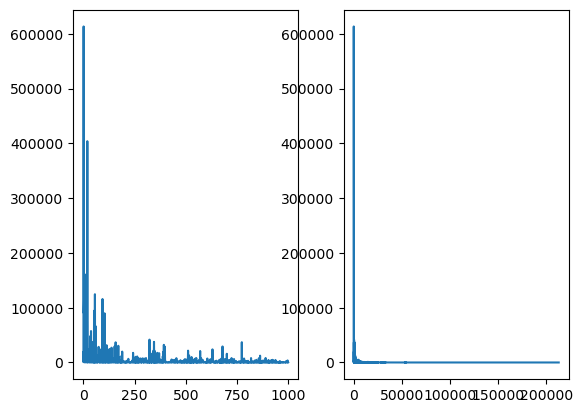

In [62]:
import matplotlib.pyplot as plt

values = [ value for value in frequency_dict.values() ]
for idx, v in enumerate(values):
    if v > 50000:
        print(list(frequency_dict.keys())[idx])
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(values[:1000])
ax2.plot(values)


## Apply a distortion function to the queries part of the corpus. In each query draw randomly one word and change one letter in the word to some other letter.

In [63]:
distorted_questions = dict()

In [64]:
print(len(ds_q))

6648


In [65]:
import random
letters = ['a', 'ą', 'b', 'c', 'ć', 'd', 'e', 'ę', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'ł', 'm', 'n', 'ń', 'o', 'ó', 'p', 'q', 'r', 's', 'ś', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ź', 'ż']

for question in ds_q:
    q_words = question['text'].split()
    if sum([len(word) for word in q_words]) <= 0: continue

    word = random.choice(q_words)
    while len(word) <= 0: word = random.choice(q_words)

    len_w = len(word)
    idx_l = int(random.randint(0, len_w-1))
    idx_w = q_words.index(word)

    word = word.replace(word[idx_l], random.choice(letters), 1)
    q_words[idx_w] = word

    distorted_questions[int(question['_id'])] = ' '.join(q_words)


In [66]:
print(distorted_questions[5993])

Dlaczego ktokolwiek miałby chcieć najpierw spłacić swoje długi t inny sposób niż „najwyższe odsetki”?


## Compute nDCG@10 for the distorted queris, using the same approach as in lab 2. This result will be the baseline for the other methods.

In [67]:
corpus_query_mapping = {} # query_id -> [corpus_ids]

for i, row in df_joined.iterrows():
    if row['query-id'] == -1:
        continue
    if row['query-id'] not in corpus_query_mapping:
        corpus_query_mapping[int(row['query-id'])] = []
    corpus_query_mapping[int(row['query-id'])].append(row['id'])

ranking = []
maxi = 0
id_maxi = -1
for query_id, corpus_ids in corpus_query_mapping.items():
    ranking.append((corpus_ids, query_id))
    if len(corpus_ids) > maxi:
        maxi = len(corpus_ids)
        id_maxi = query_id

ranking = sorted(ranking, key=lambda x: len(x[0]), reverse=True)
best_queries = []
for idx, (corpus_ids, query_id) in enumerate(ranking):
    print("query_id: ", query_id, " amount of documents: ", len(corpus_ids))
    best_queries.append(int(query_id))
    if idx == 10: break

query_id:  1505  amount of documents:  23
query_id:  3012  amount of documents:  23
query_id:  1965  amount of documents:  22
query_id:  3056  amount of documents:  21
query_id:  3476  amount of documents:  21
query_id:  2447  amount of documents:  20
query_id:  2618  amount of documents:  19
query_id:  1652  amount of documents:  19
query_id:  3299  amount of documents:  18
query_id:  3227  amount of documents:  17
query_id:  10906  amount of documents:  17


In [68]:
def calculate_ndcg(result, searching_query_id, n):
    amount_of_one = len(corpus_query_mapping[int(searching_query_id)])

    DCG = 0
    for idx, hit in enumerate(result['hits']['hits']):
        gain = 0
        corpus_id = hit['_source']['id']
        if corpus_id in corpus_query_mapping[int(searching_query_id)]:
            gain = 1
        DCG += gain / np.log2(idx + 2)
        if idx == n: break

    IDCG = 0
    for idx in range(min(amount_of_one, n)):
        IDCG += 1 / np.log2(idx + 2)

    if IDCG == 0:
        nDCG = 0
    else: 
        nDCG = DCG / IDCG

    # print("nDCG: ", nDCG)
    return nDCG

In [69]:
# ds_q [query_id]['text'] -> text
# elastic search without fuzzy match with distorted_questions [query_id] -> text
# corrected_questions [query_id] -> text
# elastic search fuzzy match with distorted_questions [query_id] -> text


def calculate_ndcg_for_best_queries(query_data, n, fuzziness: bool = False):
    ndcgs = []

    for query_id in best_queries:
        query_text = ds_q_dict[query_id]
        distorted_question = query_data[query_id]
        print("query: ", query_text, '\n',distorted_question)
        multi_match_query = {"multi_match": {"query": distorted_question, "analyzer": "polish_analyzer_synonyms_included", "fields": ["text"]}}
        fuzzy_query = {"match": {"text": {"query": distorted_question, "fuzziness": "AUTO" } } }

        if fuzziness:
            result = elasticsearch.search(index="fiqa-pl", size=n, query=fuzzy_query)
        else:
            result = elasticsearch.search(index="fiqa-pl", size=n, query=multi_match_query)
        amt_of_documents = len(result["hits"]["hits"])
        print("documents with synonyms and lemmatization: ", amt_of_documents)
        ndcg = calculate_ndcg(result, query_id, n)
        print("nDCG@"+str(n)+": ", ndcg)
        print("")
        ndcgs.append(ndcg)

    return ndcgs


In [70]:
create_with_custom_analyzer("fiqa-pl", settings, "polish_analyzer_morfologik_included")
populate_index("fiqa-pl", df_joined.to_dict(orient='records'))

/tmp/ipykernel_6196/1120335432.py:6: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  elasticsearch.bulk(operations=operations, request_timeout=120)


In [71]:
def search_query(query_id, n):
    query_text = ds_q_dict[query_id]
    distorted_question = distorted_questions[query_id]
    print("query: ", query_text, '\n',distorted_question)
    multi_match_query = {"multi_match": {"query": distorted_question, "analyzer": "polish_analyzer_synonyms_included", "fields": ["text"]}}
    query = {"match": {"text": {"query": distorted_question, "fuzziness": "AUTO" } } }

    result = elasticsearch.search(index="fiqa-pl", size=n, query=query)
    amt_of_documents = len(result["hits"]["hits"])
    print("documents with synonyms and lemmatization: ", amt_of_documents)
    ndcg4 = calculate_ndcg(result, query_id, n)

In [72]:
# search_query(5993, 10)

In [73]:
ndcg_for_distored_questions = calculate_ndcg_for_best_queries(distorted_questions, 10)

query:  Jakie mam opcje w wieku 26 lat, z 1,2 miliona USD? 
 Jakie mam opcje w wieku 26 lat, z 1,2 ziliona USD?
documents with synonyms and lemmatization:  10
nDCG@10:  0.22009176629808017

query:  Dlaczego warto kupować ubezpieczenie? 
 Dlaczego warto kupować ubyzpieczenie?
documents with synonyms and lemmatization:  10
nDCG@10:  0.0

query:  Dlaczego miałbyś kiedykolwiek odrzucić podwyżkę? 
 Dlaczego miałbyś kiedykolwiek odrzucić podwyżkę?
documents with synonyms and lemmatization:  10
nDCG@10:  0.9305687780632227

query:  Kogo naprawdę stać na luksusowe samochody? 
 Kogo naprawdę żtać na luksusowe samochody?
documents with synonyms and lemmatization:  10
nDCG@10:  0.31954962756492084

query:  Jeśli akcja nie przynosi dywidendy, to dlaczego jest cokolwiek warta? 
 Jeśli akcja nie przynosi dywidendy, to dlaczego jest cokolwiek watta?
documents with synonyms and lemmatization:  10
nDCG@10:  0.07336392209936005

query:  Dlaczego na konkurencyjnym rynku popcorn kinowy jest drogi? 
 Dlacz

## Install Morfeusz (Binding dla Pythona) and use it to find all words from the queries that do not appear in that dictionary. Only these words should be corected in the next step.

In [74]:
from morfeusz2 import Morfeusz
morfeusz = Morfeusz()

In [75]:
print(len(distorted_questions))

6648


In [76]:
words_to_correct = dict()

for id, text in distorted_questions.items():
    analysis = morfeusz.analyse(text)
    is_ign = False
    for interpretation in analysis:
        if (interpretation[2][2] == 'ign'):
            words_to_correct[id] = interpretation[2][0]
            is_ign = True
            break
    if not is_ign:
        words_to_correct[id] = text.split()[0]

## Use Levenshtein distance and the frequency list, to determine the most probable correction of the words in the queries that were identified as invalid. (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)

In [ ]:
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
from Levenshtein import distance

class DictOfWords:
    def __init__(self, frequency_dict):
        self.dict = dict()
        self.dictionary_of_words = []
        for w, no in frequency_dict.items():
            self.dictionary_of_words.append((len(w), w))

        self.dictionary_of_words = sorted(self.dictionary_of_words, key=lambda x: (x[0],x[1][0]))

    def find_similar_word(self, word):
        len_w = len(word)
        idx_left = bisect_left(self.dictionary_of_words, (len_w-1, word[0]))
        idx_right = bisect_right(self.dictionary_of_words, (len_w+1, word[0]))

        ranking_of_words = []
        for i in range(idx_left, idx_right):
            dis = distance(word, self.dictionary_of_words[i][1])
            ranking_of_words.append((dis, self.dictionary_of_words[i][1]))

        ranking_of_words = sorted(ranking_of_words, key=lambda x: x[0])
        return ranking_of_words[0][1]

dict_of_words = DictOfWords(frequency_dict)

In [78]:
corrected_questions = dict()
print(len(words_to_correct))

for q_id, malformed_word in words_to_correct.items():
    q_words = distorted_questions[q_id].split()
    try:
        idx_w = q_words.index(malformed_word)
    except ValueError:
        idx_w = -1
        min_dis = 1000
        for idx, word in enumerate(q_words):
            dis = distance(word, malformed_word)
            if dis <= min_dis:
                min_dis = dis
                idx_w = idx

    corrected_word = dict_of_words.find_similar_word(malformed_word)
    q_words[idx_w] = corrected_word
    corrected_question = ' '.join(q_words)
    corrected_questions[q_id] = corrected_question


6648


## Compute nDCG@10 for your implementation of the spelling correction method.

In [79]:
ndcg_for_corrected_questions = calculate_ndcg_for_best_queries(corrected_questions, 10)

query:  Jakie mam opcje w wieku 26 lat, z 1,2 miliona USD? 
 Jakie mam opcje w wieku 26 lat, z 1,2 biliona USD?
documents with synonyms and lemmatization:  10
nDCG@10:  0.22009176629808017

query:  Dlaczego warto kupować ubezpieczenie? 
 Dlaczego warto kupować ubezpieczenie
documents with synonyms and lemmatization:  10
nDCG@10:  0.07839826897867533

query:  Dlaczego miałbyś kiedykolwiek odrzucić podwyżkę? 
 Dlaczego miałbyś kiedykolwiek odrzucić podwyżkę?
documents with synonyms and lemmatization:  10
nDCG@10:  0.9305687780632227

query:  Kogo naprawdę stać na luksusowe samochody? 
 Kogo naprawdę Stać na luksusowe samochody?
documents with synonyms and lemmatization:  10
nDCG@10:  0.3822360008387524

query:  Jeśli akcja nie przynosi dywidendy, to dlaczego jest cokolwiek warta? 
 Jeśli akcja nie przynosi dywidendy, to dlaczego jest cokolwiek watta?
documents with synonyms and lemmatization:  10
nDCG@10:  0.07336392209936005

query:  Dlaczego na konkurencyjnym rynku popcorn kinowy jest 

## Use ElasticSearch's fuzzy match and compute nDCG@10 for this approach.

In [80]:
ndcg_for_distorted_questions_with_fuzziness = calculate_ndcg_for_best_queries(distorted_questions, 10, True)

query:  Jakie mam opcje w wieku 26 lat, z 1,2 miliona USD? 
 Jakie mam opcje w wieku 26 lat, z 1,2 ziliona USD?
documents with synonyms and lemmatization:  10
nDCG@10:  0.07839826897867533

query:  Dlaczego warto kupować ubezpieczenie? 
 Dlaczego warto kupować ubyzpieczenie?
documents with synonyms and lemmatization:  10
nDCG@10:  0.08514311764162098

query:  Dlaczego miałbyś kiedykolwiek odrzucić podwyżkę? 
 Dlaczego miałbyś kiedykolwiek odrzucić podwyżkę?
documents with synonyms and lemmatization:  10
nDCG@10:  0.696162268139923

query:  Kogo naprawdę stać na luksusowe samochody? 
 Kogo naprawdę żtać na luksusowe samochody?
documents with synonyms and lemmatization:  10
nDCG@10:  0.26462022272743835

query:  Jeśli akcja nie przynosi dywidendy, to dlaczego jest cokolwiek warta? 
 Jeśli akcja nie przynosi dywidendy, to dlaczego jest cokolwiek watta?
documents with synonyms and lemmatization:  10
nDCG@10:  0.25880978898961277

query:  Dlaczego na konkurencyjnym rynku popcorn kinowy jest

## 13. Compare the results of baseline with the 2 implemented methods. Take into account the nDCG score and the performance of the methods.

In [81]:
print("nDCG@10 scores:")
print("distorted questions | corrected questions | distorted questions with fuzziness")
for (ndcg1, ndcg2, ndcg3) in zip(ndcg_for_distored_questions, ndcg_for_corrected_questions, ndcg_for_distorted_questions_with_fuzziness):
    print(round(ndcg1, 3), '  |  ', round(ndcg2, 3), '  |  ', round(ndcg3, 3))
print("means of nDCG@10: ")
print(round(np.mean(ndcg_for_distored_questions), 3), '  |  ', round(np.mean(ndcg_for_corrected_questions), 3), '  |  ', round(np.mean(ndcg_for_distorted_questions_with_fuzziness), 3))

nDCG@10 scores:
distorted questions | corrected questions | distorted questions with fuzziness
0.22   |   0.22   |   0.078
0.0   |   0.078   |   0.085
0.931   |   0.931   |   0.696
0.32   |   0.382   |   0.265
0.073   |   0.073   |   0.259
1.0   |   1.0   |   1.0
0.0   |   0.0   |   0.069
0.51   |   0.51   |   0.454
0.066   |   0.066   |   0.0
0.205   |   0.205   |   0.139
0.22   |   0.139   |   0.22
means of nDCG@10: 
0.322   |   0.328   |   0.297


Best results are achieved for introduced method that is using Levenshtein. But it has also the worst performance of them all.

## 14. Use an LLM of your choice (you can use [Bielik](https://chat.bielik.ai/)) to fix 30 first queries from the distorted set and compare the results manually with the method based on the Levenshtein distance.

I have chosen ChatGPT

In [82]:
first_30_questions = dict()

for idx, q in enumerate(distorted_questions.items()):
    first_30_questions[q[0]] = q[1]
    print(q[0],q[1])
    if idx == 30: break


0 Co jest uważane za wydatek służbowy ż podróży służbowej?
4 Wydatki służbowe - ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży służboweł
5 Rozpoczęcie nowego biznesu odline
6 „Dzień robocry” i „termin płatności” rachunków
7 Nswy właściciel firmy – Jak działają podatki dla firmy i osoby fizycznej?
9 Hozby kontra biznes
11 Czeki osobiste zampast firmowych
12 Czy amerykański kodeks podatkowy wymaga, aby właściciele małych firm liczyli zakupy biznesowe jako docród osobisty?
13 Jak mogę zarejestrowau firmę w Wielkiej Brytanii bez podawania adresu firmy?
14 Czym sv „podstawy biznesowe”?
16 Strata na inwestycjach biznesowych j poprzedniego roku
19 Jak mogę oszacować podatki biznesowe / opłaty za zgłoszenie dla firmr, która ma 0 USD dochodu?
20 Czy zakup samochodu dla firźy za pomocą kredytu biznesowego zostałby uznany za wydatek biznesowy?
21 Odliczanie strat biznesowych z ostatnich ldt (nieudokumentowanych)
23 30% uiziału w biznesie
25 Odbierani

In [83]:
corrected_question_with_ChatGPT = [
    "Co jest uważane za wydatek służbowy w podróży służbowej?",
    "Wydatki służbowe – ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży służbowej.",
    "Rozpoczęcie nowego biznesu online.",
    "„Dzień roboczy” i „termin płatności” rachunków.",
    "Nowy właściciel firmy – jak działają podatki dla firmy i osoby fizycznej?",
    "Hobby kontra biznes.",
    "Czeki osobiste zamiast firmowych.",
    "Czy amerykański kodeks podatkowy wymaga, aby właściciele małych firm liczyli zakupy biznesowe jako dochód osobisty?",
    "Jak mogę zarejestrować firmę w Wielkiej Brytanii bez podawania adresu firmy?",
    "Czym są „podstawy biznesowe”?",
    "Strata na inwestycjach biznesowych z poprzedniego roku.",
    "Jak mogę oszacować podatki biznesowe/opłaty za zgłoszenie dla firmy, która ma 0 USD dochodu?",
    "Czy zakup samochodu dla firmy za pomocą kredytu biznesowego zostałby uznany za wydatek biznesowy?",
    "Odliczanie strat biznesowych z ostatnich lat (nieudokumentowanych).",
    "3% udziału w biznesie.",
    "Odbieranie wydatków służbowych z osobistej karty kredytowej.",
    "Używanie czeku biznesowego do płatności w handlu detalicznym.",
    "Podatek przy zakładaniu firmy na pełen etat.",
    "Czy mogę spłacić saldo karty kredytowej, aby zwolnić dostępny kredyt?",
    "Powolne rozpoczynanie działalności pobocznej.",
    "Dlaczego „spieniężanie czeków” jest legalną działalnością?",
    "Czy biznes to jedyny sposób na zostanie milionerem?",
    "Wycena małej firmy, w którą warto zainwestować.",
    "Rozpoczęcie dużego biznesu z niewielkimi dochodami.",
    "Wymagania dotyczące rozliczania podatków biznesowych.",
    "Ubezpieczenie zdrowotne do pracy i mojej firmy.",
    "Doradztwo w zakresie transferu pieniędzy.",
    "Jak przenieść leasing samochodu osobistego na leasing samochodu biznesowego?",
    "Korepetycje z zarządzania płacami biznesowymi.",
    "Czy jako właściciel małej firmy powinienem płacić podatki z mojego osobistego lub firmowego konta czekowego?",
    "Czy biznes mojego męża powinien opłacać mój biznes?"
]

In [ ]:
def calculate_ndcg_for_query(query_id, cnt_idx, n):

    distorted_question = distorted_questions[query_id]
    multi_match_query = {"multi_match": {"query": distorted_question, "analyzer": "polish_analyzer_synonyms_included", "fields": ["text"]}}
    result = elasticsearch.search(index="fiqa-pl", size=n, query=multi_match_query)
    ndcg = calculate_ndcg(result, query_id, n)

    corrected_question = corrected_questions[query_id]
    multi_match_query = {"multi_match": {"query": corrected_question, "analyzer": "polish_analyzer_synonyms_included", "fields": ["text"]}}
    result = elasticsearch.search(index="fiqa-pl", size=n, query=multi_match_query)
    ndcg2 = calculate_ndcg(result, query_id, n)

    chatGPT_question = corrected_question_with_ChatGPT[cnt_idx]
    multi_match_query = {"multi_match": {"query": chatGPT_question, "analyzer": "polish_analyzer_synonyms_included", "fields": ["text"]}}
    result = elasticsearch.search(index="fiqa-pl", size=n, query=multi_match_query)
    ndcg3 = calculate_ndcg(result, query_id, n)

    return ndcg, ndcg2, ndcg3

In [85]:
cnt_idx = 0
ndcg1s = []
ndcg2s = []
ndcg3s = []

for q_id in first_30_questions.keys():
    print("===============================", cnt_idx, "====================================")
    print("Original question: \n", ds_q_dict[q_id])
    print("Question with typo: \n", first_30_questions[q_id])
    print("Corrected question with custom algorithm with Levenshtein: \n", corrected_questions[q_id])
    print("Corrected question with ChatGPT: \n", corrected_question_with_ChatGPT[cnt_idx])
    print("")
    print("nDCG@10 scores:")
    print("distorted questions | corrected questions | ChatGPT questions")
    ndcg1, ndcg2, ndcg3 = calculate_ndcg_for_query(q_id, cnt_idx, 10)
    ndcg1s.append(ndcg1)
    ndcg2s.append(ndcg2)
    ndcg3s.append(ndcg3)
    print(round(ndcg1, 3), '  |  ', round(ndcg2, 3), '  |  ', round(ndcg3, 3))
    print("")
    
    cnt_idx += 1

print("nDCG@10 mean scores:")
print("distorted questions | corrected questions | ChatGPT questions")
print(round(np.mean(ndcg1s), 3), '  |  ', round(np.mean(ndcg2s), 3), '  |  ', round(np.mean(ndcg3s), 3))


=============================== 0 ====================================
Original question: 
 Co jest uważane za wydatek służbowy w podróży służbowej?
Question with typo: 
 Co jest uważane za wydatek służbowy ż podróży służbowej?
Corrected question with custom algorithm with Levenshtein: 
 Co jest uważane za wydatek służbowy   podróży służbowej?
Corrected question with ChatGPT: 
 Co jest uważane za wydatek służbowy w podróży służbowej?

nDCG@10 scores:
distorted questions | corrected questions | ChatGPT questions
0.0   |   0.0   |   0.0

=============================== 1 ====================================
Original question: 
 Wydatki służbowe - ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży służbowej
Question with typo: 
 Wydatki służbowe - ubezpieczenie samochodu podlegające odliczeniu za wypadek, który wydarzył się podczas podróży służboweł
Corrected question with custom algorithm with Levenshtein: 
 Wydatki służbowe - ubezpieczenie samo

## Draw conclusions regarding (2 points):
  * the distribution of words in the corpus,\
    **There were a lot of different words in the corpus. Most frequent were conjunctions and stop words.\
      It was time-consuming for my method to find the most similar word, because of vast diversity.**

  * the performance of your method compared to ElasticSearch,\
    **The performance of the used method takes much more time compared to ElasticSearch. \
      In the introduced method I need to check Levenshtein distance of all words that differed in length at maximum 1 letter.**

  * the results provided by your method compared to ElasticSearch,\
    **Considering nDCG my method was better in correcting words. It achieved slightly better results e.g. 0.328 > 0.297.\
    But ES fuzzy-match is more advanced method and could cope with more advanced errors.**

  * the validity of the obtained corrections,\
    **My method was more precise but sometimes failed completely. It couldn't recognize mistakes, instead, it took foreign words as flawed.\
      There were also other mistakes. It failed to find a word to correct. It was able to replace a word with a very similar, but still not exact one.**

  * ability of an LLM to fix invalid queries.\
    **I used ChatGPT to correct invalid queries. To my surprise, it wasn't as good as I thought, because instead of just correcting words it also\
      rephrased sentences to ones with similar meaning, but with different words. It corrected errors where there was no need to do this.\
      It struggled with predicting numbers because it couldn't guess the correct one.\
      LLMs are not perfect tools with their flaws and always should be taken with a pinch of salt.**
    
